In [1]:
#default package
import logging
import pickle
#third package
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
# reload
%load_ext autoreload
%autoreload 2

In [3]:
# logger 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# graph setting
sns.set()

In [5]:
# random seed
np.random.seed(seed=1)

## 推定対象

In [6]:
#setting
radius=1
t_num=30
beacon_num=4

In [7]:
def generate_data(t_num:int,radius:float,noise_mag:float=0.05)->pd.DataFrame:
    """
    2 dimensinalノイズ付き半円上を動く物体移動データ生成
    """
    pos_df=pd.DataFrame(columns=["x_pos","y_pos"])
    for t in range(t_num):
        noise=noise_mag*np.random.randn(2)
        theta=np.pi*t/t_num
        pos=np.array([np.cos(theta)-radius,np.sin(theta)])+noise
        pos_series=pd.Series(pos,index=pos_df.columns)
        pos_df=pos_df.append(pos_series,ignore_index=True)
    return pos_df

In [8]:
def generate_beacon_data(t_num:int,beacon_num:int,radius:float,noise_mag:float=0.2)->pd.DataFrame:
    """
    物体の周りにbeacon位置データ生成
    """
    beacon_pos_df=pd.DataFrame(columns=["x_pos","y_pos"])
    for beacon in range(beacon_num):
        noise=noise_mag*np.random.randn(2)
        theta=np.pi*beacon/beacon_num
        beacon_pos=np.array([np.cos(theta)-radius,np.sin(theta)])+noise
        beacon_pos_series=pd.Series(beacon_pos,index=beacon_pos_df.columns)
        beacon_pos_df=beacon_pos_df.append(beacon_pos_series,ignore_index=True)
    return beacon_pos_df

In [9]:
#tracked object
pos_df=generate_data(t_num,radius)
#beacon position
beacon_pos_df=generate_beacon_data(t_num,beacon_num,radius)

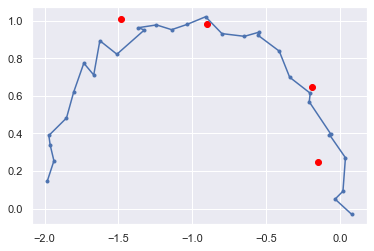

In [10]:
plt.plot(pos_df['x_pos'],pos_df['y_pos'],marker='.')
plt.scatter(beacon_pos_df['x_pos'],beacon_pos_df['y_pos'],color='red')

## 観測データ

In [11]:
#RSSI setting
a=5
b=1

In [12]:
def calc_rssi(pos_df:pd.DataFrame,beacon_pos_df:pd.DataFrame,a:float,b:float,noise_mag:float=0.5)->pd.DataFrame:
    """
    物体の真の位置とビーコンの位置からideal RSSIを計算する
    ideal RSSIにノイズを加えた観測RSSIを返す
    RSSI算出には距離減衰モデルを用いる
    """
    dist_df=pd.DataFrame(columns=beacon_pos_df.index)
    for idx,beacon_pos in enumerate(beacon_pos_df.values):
        dist_df[idx]=np.sqrt((pos_df['x_pos']-beacon_pos[0])**2+(pos_df['y_pos']-beacon_pos[1])**2)
    
    _dist_to_rssi=lambda x: -a*np.log(x)+b+noise_mag*np.random.randn()

    return dist_df.applymap(_dist_to_rssi)

<AxesSubplot:>

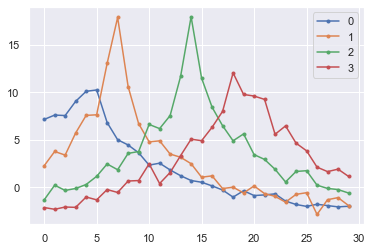

In [13]:
obs_df=calc_rssi(pos_df,beacon_pos_df,a,b)
obs_df.plot(marker='.')

## 物体位置のベイズ推定

In [14]:
#default package
import glob
#third package
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro import sample, plate, handlers
import funsor
import cv2

In [15]:
 def model(obs_df:pd.DataFrame,beacon_pos_df:pd.DataFrame,beacon_num:int,a:float,b:float,mu:float=0,sigma1:float=10,sigma2:float=10):
    pm_x0 = sample('pm_x0', dist.Normal(mu, sigma1))
    pm_x1 = sample('pm_x1', dist.Normal(mu, sigma1))
    
    for i in range(beacon_num):
        y_bar=-a/2*jnp.log((beacon_pos_df.iloc[i]['x_pos']-pm_x0)**2+(beacon_pos_df.iloc[i]['y_pos']-pm_x1)**2) +b
        pm_y = sample('pm_y_%s'%(i), dist.Normal(y_bar, sigma2), obs=obs_df[i])
 
    return pm_y

In [17]:
# Run MCMC
mcmc_list=[]
for t in range(t_num):
    logger.info(f"infering time:{t}")
    kernel = infer.NUTS(model)
    mcmc_list.append(infer.MCMC(kernel, num_warmup=1000, num_samples=2000))
    mcmc_list[-1].run(rng_key=random.PRNGKey(0), obs_df=obs_df.iloc[t],beacon_pos_df=beacon_pos_df,beacon_num=beacon_num,a=a,b=b)
    #mcmc.print_summary()
 


INFO:__main__:infering time:0
sample: 100%|██████████| 3000/3000 [00:04<00:00, 626.91it/s, 3 steps of size 5.74e-01. acc. prob=0.84]
INFO:__main__:infering time:1
sample: 100%|██████████| 3000/3000 [00:04<00:00, 617.24it/s, 3 steps of size 5.66e-01. acc. prob=0.86]
INFO:__main__:infering time:2
sample: 100%|██████████| 3000/3000 [00:04<00:00, 638.75it/s, 7 steps of size 3.53e-01. acc. prob=0.92]
INFO:__main__:infering time:3
sample: 100%|██████████| 3000/3000 [00:04<00:00, 658.70it/s, 7 steps of size 5.45e-01. acc. prob=0.79]
INFO:__main__:infering time:4
sample: 100%|██████████| 3000/3000 [00:04<00:00, 658.17it/s, 1 steps of size 4.53e-01. acc. prob=0.83]
INFO:__main__:infering time:5
sample: 100%|██████████| 3000/3000 [00:04<00:00, 643.28it/s, 3 steps of size 3.03e-01. acc. prob=0.88]
INFO:__main__:infering time:6
sample: 100%|██████████| 3000/3000 [00:04<00:00, 654.56it/s, 3 steps of size 6.05e-01. acc. prob=0.77]
INFO:__main__:infering time:7
sample: 100%|██████████| 3000/3000 [00:

INFO:__main__:plotting time:0
INFO:__main__:plotting time:1
INFO:__main__:plotting time:2
INFO:__main__:plotting time:3
INFO:__main__:plotting time:4
INFO:__main__:plotting time:5
INFO:__main__:plotting time:6
INFO:__main__:plotting time:7
INFO:__main__:plotting time:8
INFO:__main__:plotting time:9
INFO:__main__:plotting time:10
INFO:__main__:plotting time:11
INFO:__main__:plotting time:12
INFO:__main__:plotting time:13
INFO:__main__:plotting time:14
INFO:__main__:plotting time:15
INFO:__main__:plotting time:16
INFO:__main__:plotting time:17
INFO:__main__:plotting time:18
INFO:__main__:plotting time:19
INFO:__main__:plotting time:20
INFO:__main__:plotting time:21
INFO:__main__:plotting time:22
INFO:__main__:plotting time:23
INFO:__main__:plotting time:24
INFO:__main__:plotting time:25
INFO:__main__:plotting time:26
INFO:__main__:plotting time:27
INFO:__main__:plotting time:28
INFO:__main__:plotting time:29


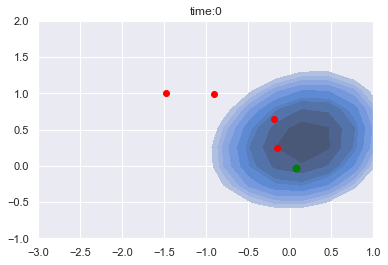

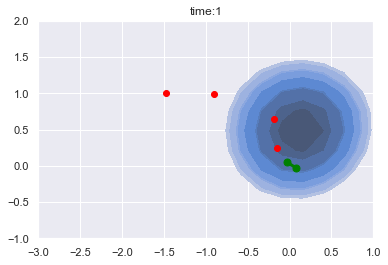

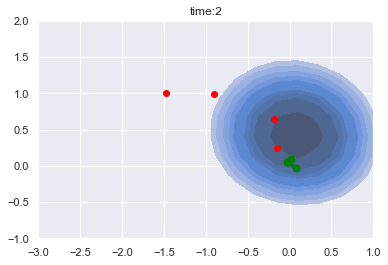

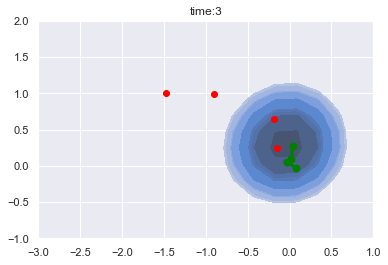

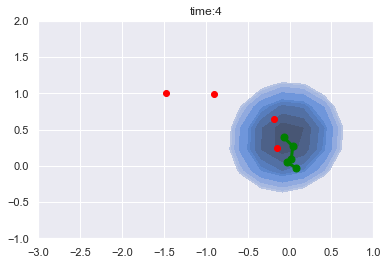

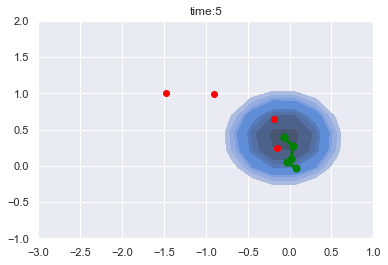

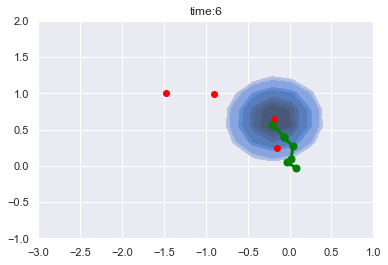

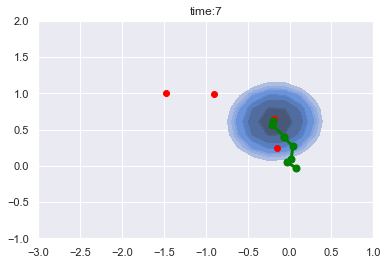

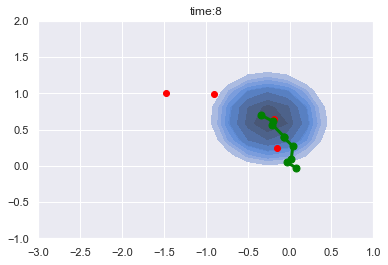

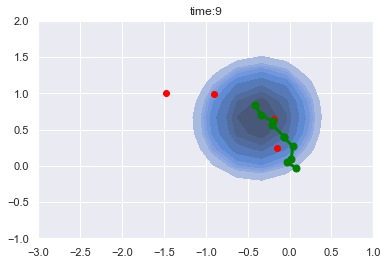

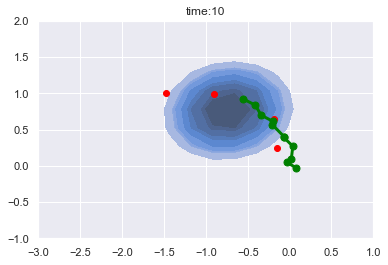

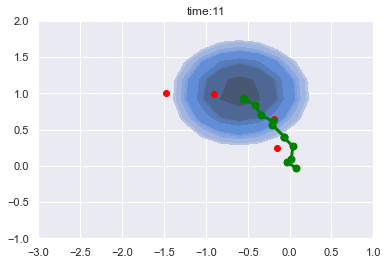

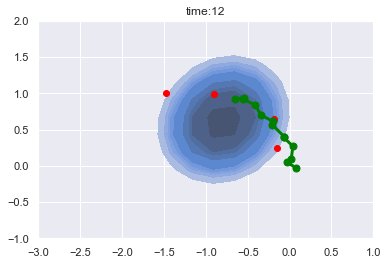

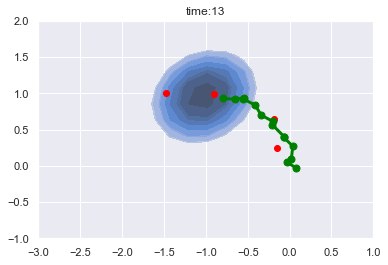

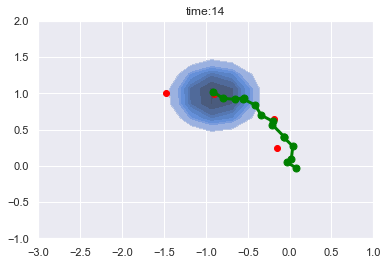

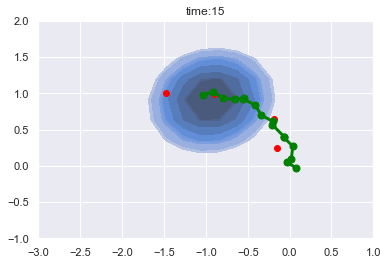

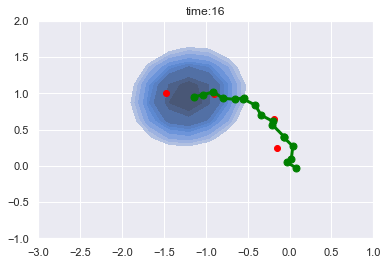

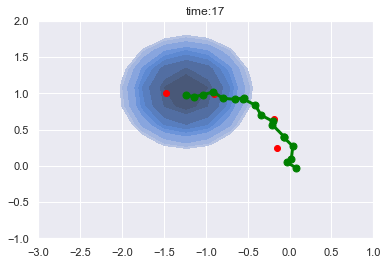

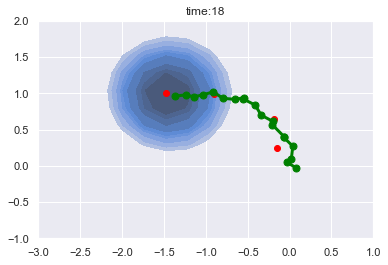

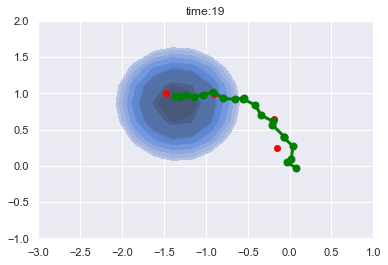

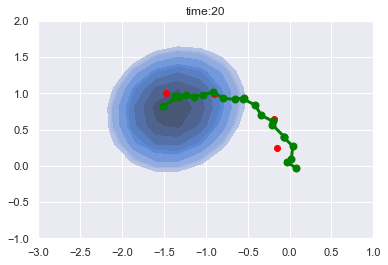

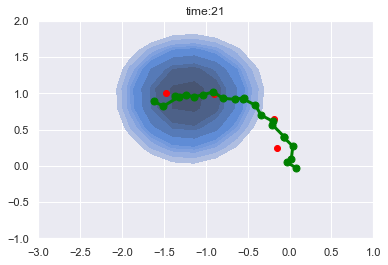

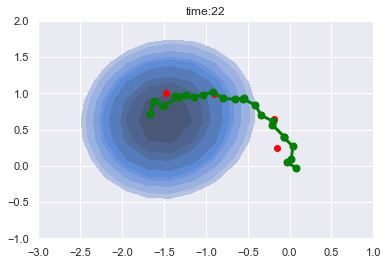

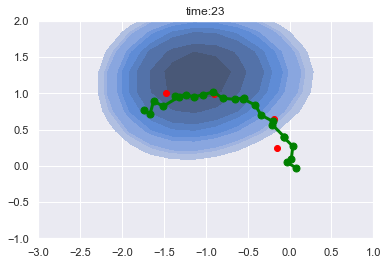

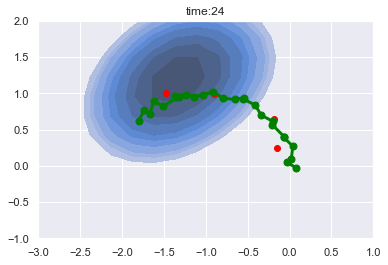

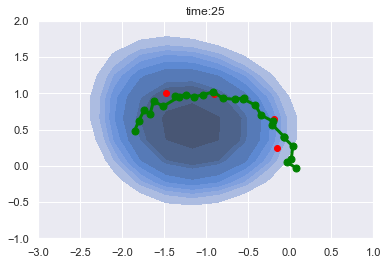

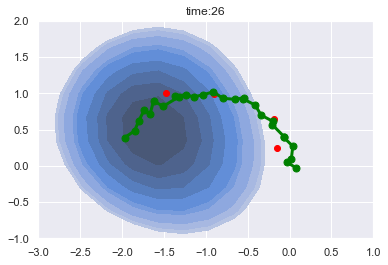

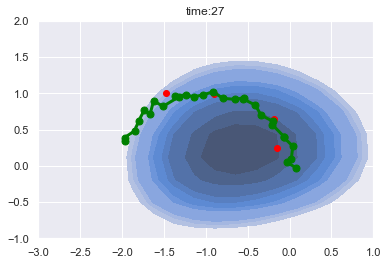

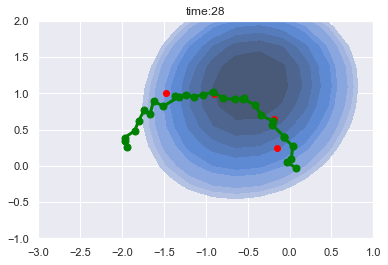

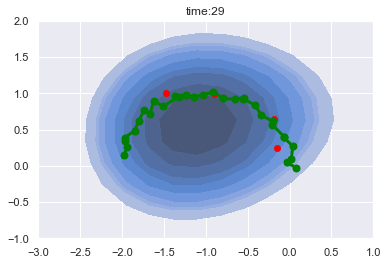

In [24]:
# plot
for t in range(t_num):
    logger.info(f"plotting time:{t}")
    plt.figure()
    mcmc_samples = mcmc_list[t].get_samples()
    pm_x0 = mcmc_samples["pm_x0"]
    pm_x1 = mcmc_samples["pm_x1"]
    sns.kdeplot(pm_x0,pm_x1,shade=True,thresh=0.96)
    plt.plot(pos_df.iloc[:t+1,0],pos_df.iloc[:t+1,1],color='green',marker='o',markersize=7,linewidth=3)
    plt.scatter(beacon_pos_df['x_pos'],beacon_pos_df['y_pos'],color='red')
    plt.ylim(-1,2)
    plt.xlim(-3,1)
    plt.title('time:%s'%t)
    plt.savefig('./movie/plot_time%s.png'%(t))

In [23]:
# generate movie
img_array = []
for i in range(t_num):
    img = cv2.imread("./movie/plot_time%s.png"% i)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

name = 'bpe.mp4'
out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'MP4V'), 5.0, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## 物体位置の推定(マルコフ性を仮定)

In [30]:
 def model_markov(obs_df:pd.DataFrame,beacon_pos_df:pd.DataFrame,beacon_num:int,a:float,b:float,mu:float=0,sigma1:float=10,sigma2:float=10):
    pm_x0 = sample('pm_x0', dist.GaussianRandomWalk(scale=sigma1, num_steps=len(obs_df)))
    pm_x1 = sample('pm_x1', dist.GaussianRandomWalk(scale=sigma1, num_steps=len(obs_df)))
    
    for i in range(beacon_num):
        y_bar=-a/2*jnp.log((beacon_pos_df.iloc[i]['x_pos']-pm_x0)**2+(beacon_pos_df.iloc[i]['y_pos']-pm_x1)**2) +b
        pm_y = sample('pm_y_%s'%(i), dist.Normal(y_bar, sigma2), obs=obs_df[i])
 
    return pm_y

In [32]:
# Run MCMC
logger.info(f"infering time:{t}")
kernel = infer.NUTS(model_markov)
mcmc=infer.MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), obs_df=obs_df,beacon_pos_df=beacon_pos_df,beacon_num=beacon_num,a=a,b=b)
#mcmc.print_summary()

INFO:__main__:infering time:29


Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([ 8.337951    9.737606    9.836353    5.0633545  12.085315   10.683408
  8.305422    8.863035    6.428494    2.0848331   4.039075    0.04278946
  2.1530094   3.0199828  -0.27417284  2.5388105   2.1635487  -0.46896866
 -0.290784   -2.5925817  -2.1382587   0.13434917  1.5741959   0.06777298
  0.822171   -7.008175   -0.04463732  0.52242315  0.5241561  -2.272527  ])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([ 8.337951  ,  9.737606  ,  9.836353  ,  5.0633545 ,
                             12.085315  , 10.683408  ,  8.305422  ,  8.863035  ,
                              6.428494  ,  2.0848331 ,  4.039075  ,  0.04278946,
                              2.1530094 ,  3.0199828 , -0.27417284,  2.5388105 ,
                              2.1635487 , -0.46896866, -0.290784  , -2.5925817 ,
                             -2.1382587 ,  0.13434917,  1.5741959 ,  0.06777298,
                              0.822171  , -7.008175  , -0.04463732,  0.52242315,
                              0.5241561 , -2.272527  ], dtype=float32)
       tangent = Traced<ShapedArray(float32[30]):JaxprTrace(level=1/0)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.